In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np

db=mysql.connector.connect(host="localhost",
                          username='root',
                          password='1234',
                          database='ecommerce')

cur=db.cursor()

# List all unique cities where customers are located

In [3]:
query='select distinct(customer_city) from customers'
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['City'])
df

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017

In [51]:
query='select count(order_id) from orders where year(order_purchase_timestamp)=2017'
cur.execute(query)
data=cur.fetchall()
print('The total order placed are',data[0][0])

The total order placed are 45101


# Find the top 5 total sales per category

In [7]:
query="""select upper(p.product_category) as category,round(sum(payments.payment_value),2) as Sales
from products as p join order_items as o on o.product_id=p.product_id join
payments on payments.order_id=o.order_id group by category order by Sales desc limit 5"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=['Category','Sales'])
df

,Category,Sales
0,BED TABLE BATH,1712553.67
1,HEALTH BEAUTY,1657373.12
2,COMPUTER ACCESSORIES,1585330.45
3,FURNITURE DECORATION,1430176.39
4,WATCHES PRESENT,1429216.68


# Calculate the percentage of orders that were paid in installments

In [9]:
query="""select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100 from payments"""
cur.execute(query)
data=cur.fetchall()
data

[(Decimal('99.9981'),)]

# Count the number of customers from each state

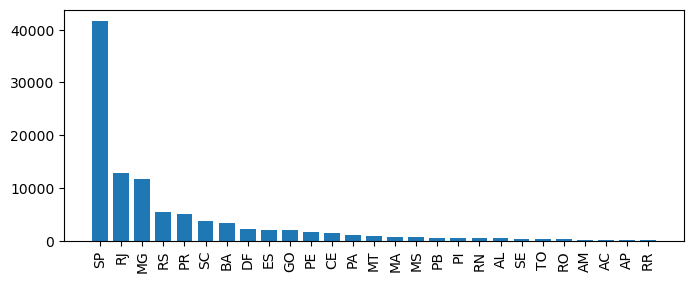

In [11]:
query="""select customer_state, count(customer_id) from customers group by customer_state"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['State','Customer_count'])
df=df.sort_values(by='Customer_count',ascending=False)
plt.figure(figsize=(8,3))
plt.bar(df['State'],df['Customer_count'],width=0.75)
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018

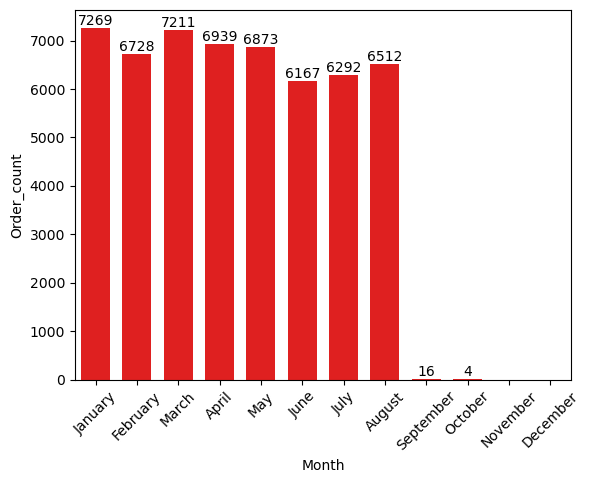

<Figure size 1000x400 with 0 Axes>

In [13]:
query="""select monthname(order_purchase_timestamp),count(order_id) from orders where
 year(order_purchase_timestamp)=2018 group by monthname(order_purchase_timestamp)"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Month','Order_count'])
o=['January','February','March','April','May','June','July','August','September','October','November','December']
values=sns.barplot(x=df['Month'],y=df['Order_count'],data=df,order=o,color='red',width=0.7)
plt.xticks(rotation=45)
plt.figure(figsize=(10,4))
values.bar_label(values.containers[0])
plt.show()

# Find the average number of products per order, grouped by customer city

In [15]:
query="""with count_per_order as (select orders.order_id,orders.customer_id,count(order_items.order_id) as oc from
orders join order_items on orders.order_id=order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(oc),2) as avg_orders from customers join
count_per_order on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by avg_orders desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['City','Avg Count/order'])
df.head(10)

,City,Avg Count/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category

In [29]:
query="""select upper(p.product_category) as category,round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) 
as sales_percentage from products as p join order_items as o on o.product_id=p.product_id join
payments on payments.order_id=o.order_id group by category order by sales_percentage desc"""
cur.execute(query)
data=cur.fetchall()
data
df=pd.DataFrame(data,columns=['Category','Sales_Percentage'])
df.head(10)

,Category,Sales_Percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# Identify the correlation between product price and the number of times a product has been purchased

In [53]:
query="""select products.product_category,count(order_items.product_id), round(avg(order_items.price),2)
from products join order_items on products.product_id=order_items.product_id group by 
products.product_category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Category','Order Count','Avg Price'])

arr1=df['Order Count']
arr2=df['Avg Price']

a=np.corrcoef([arr1,arr2])
print('The correlation between product price and the number of times a product has been purchased',a[0][-1])

The correlation between product price and the number of times a product has been purchased -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue

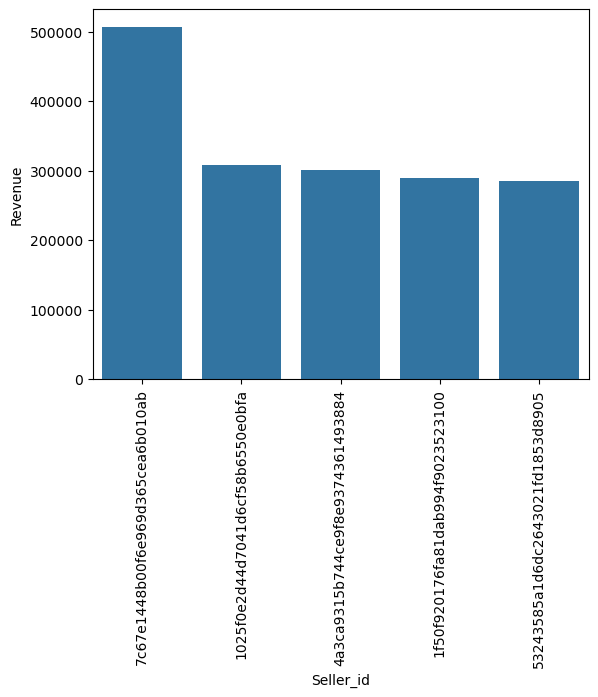

In [85]:
query="""select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id,round(sum(payments.payment_value),2) revenue from payments 
join order_items on payments.order_id=order_items.order_id 
group by order_items.seller_id) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Seller_id','Revenue','Rank'])
df=df.head()
sns.barplot(x='Seller_id',y='Revenue',data=df)
plt.xticks(rotation=90)
plt.show()

# Calculate the moving average of order values for each customer over their order history

In [92]:
query="""select customer_id,order_purchase_timestamp,payment, avg(payment)
over (partition by customer_id order by order_purchase_timestamp rows between 
2 preceding and current row) as moving_avg from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value payment from 
payments join orders on orders.order_id=payments.order_id) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Customer_id','Timestamp','Payment','Avg_Payment'])
df

,Customer_id,Timestamp,Payment,Avg_Payment
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year

In [95]:
query="""select Years,Months,round(sum(payment) over (order by years,months),2) as Cumulative_sales from
(select year(orders.order_purchase_timestamp) as Years ,month(orders.order_purchase_timestamp) as Months,
round(sum(payments.payment_value),2) as Payment from orders join payments on
orders.order_id=payments.order_id group by years,months) as a"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Year','Month','Cumulative_sale'])
df

,Year,Month,Cumulative_sale
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39
5,2017,3,939621.99
6,2017,4,1357410.02
7,2017,5,1950328.84
8,2017,6,2461605.22
9,2017,7,3053988.14


# Calculate the year-over-year growth rate of total sales

In [30]:
query="""with a as (select year(orders.order_purchase_timestamp) as Years,
round(sum(payments.payment_value),2) as Payment from orders join payments on
orders.order_id=payments.order_id group by years order by years)

select Years,((Payment-lag(Payment,1) over (order by Years))/lag(Payment,1) over (order by Years))*100 from a
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Year','YoY % Growth'])
df

,Year,YoY % Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Identify the top 3 customers who spent the most money in each year

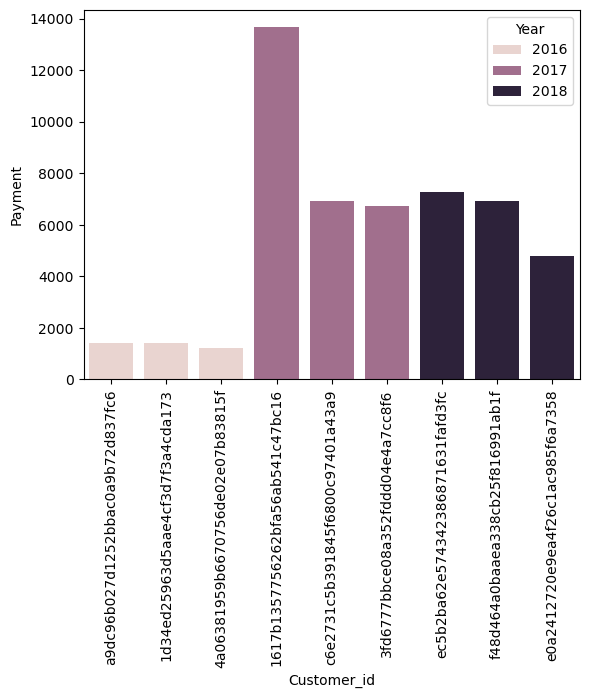

In [38]:
query="""select years, customer_id,Payment, d_rank from
(select year(orders.order_purchase_timestamp) years, orders.customer_id,
sum(payments.payment_value) Payment, dense_rank()
over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) as d_rank
from orders join payments on 
payments.order_id=orders.order_id group by 
year(orders.order_purchase_timestamp),orders.customer_id) as a
where d_rank<=3"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Year','Customer_id','Payment','Rank'])
df
sns.barplot(x='Customer_id',y='Payment',data=df,hue='Year')
plt.xticks(rotation=90)
plt.show()